# Tutorial: A Gaussian Mixture Model

In this tutorial, we demonstrate how to use the `GaussianMixture` class:

- Fit the GMM with various covariance types (full, diag, spherical, tied).
- Explore different initialization methods (random, points, kpp, kmeans, maxdist).
- Visualize model results, including responsibilities and generated samples.

### Imports and Setup
In this cell, we import the necessary packages: PyTorch for our model, NumPy for data manipulation, and Matplotlib for plotting. We also import our custom GaussianMixture class from our module.

We then set a random seed (for reproducibility) and define a device (CPU or GPU).



In [148]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import importlib
import os

#print(os.getcwd())
os.chdir('../')

import src.gmm
import src.metrics
importlib.reload(src.gmm)
importlib.reload(src.metrics)
from src.gmm import GaussianMixture

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 0
np.random.seed(random_state)
torch.manual_seed(random_state)


### Helper function for plots

In [149]:
def plot_gmm_results(
    gmm,
    X,
    labels,
    ax=None,
    title='GMM Results',
    init_means=None
):
    """
    Plot data points colored by cluster, the final GMM ellipses,
    and optionally the initial means in red.

    Parameters
    ----------
    gmm : GaussianMixture
        A fitted GaussianMixture instance.
    X : np.ndarray
        Original 2D data (shape: (N, 2)).
    labels : np.ndarray
        Predicted cluster labels for each point in X.
    ax : matplotlib.axes.Axes
        Axes on which to plot. If None, uses current Axes.
    title : str
        Title for the subplot.
    init_means : torch.Tensor or None
        Initial means (k, 2) if you want to display them in red '+'.
    """
    if ax is None:
        ax = plt.gca()

    # Distinct colors for each cluster
    cmap = ListedColormap(plt.cm.Dark2(np.linspace(0, 1, gmm.n_components)))

    # Plot data points by predicted labels
    for i, color in zip(range(gmm.n_components), cmap.colors):
        mask = (labels == i)
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=2, label=f'Cluster {i}', alpha=0.6)

    # Plot final means & covariances
    for n, color in zip(range(gmm.n_components), cmap.colors):
        mean = gmm.means_[n].detach().cpu().numpy()

        # Determine the covariance based on gmm.covariance_type
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'diag':
            diag_vals = gmm.covariances_[n].detach().cpu().numpy()
            cov = np.diag(diag_vals)
        elif gmm.covariance_type == 'spherical':
            var = gmm.covariances_[n].detach().cpu().item()  # scalar
            cov = np.eye(gmm.n_features) * var
        elif gmm.covariance_type == 'tied_full':
            cov = gmm.covariances_.detach().cpu().numpy()  # single shared matrix
        elif gmm.covariance_type == 'tied_diag':
            diag_vals = gmm.covariances_.detach().cpu().numpy()
            cov = np.diag(diag_vals)
        elif gmm.covariance_type == 'tied_spherical':
            var = gmm.covariances_.detach().cpu().item()
            cov = np.eye(gmm.n_features) * var
        else:
            raise ValueError(f"Unsupported covariance_type: {gmm.covariance_type}")

        # Decompose covariance to plot an ellipse
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        # Plot ellipses for 1,2,3 std devs
        for std_dev, alpha_ellipse in zip([1, 2, 3], [0.3, 0.2, 0.1]):
            width, height = 2 * np.sqrt(vals) * std_dev
            e = Ellipse(
                mean,
                width=width,
                height=height,
                angle=angle,
                facecolor=color,
                alpha=alpha_ellipse,
                edgecolor=None
            )
            ax.add_patch(e)

        # Mark final mean as black circle
        ax.plot(mean[0], mean[1], 'ko', markersize=4)

    # Optionally plot the initial means in red
    if init_means is not None:
        init_means_cpu = init_means.detach().cpu().numpy()
        for i in range(gmm.n_components):
            ax.plot(init_means_cpu[i, 0], init_means_cpu[i, 1], 'r+', markersize=10, markeredgewidth=2)

    ax.set_title(title)
    ax.axis('equal')


### Generating Synthetic Data
We create synthetic data that comes from a mixture of Gaussians. In our example, we generate two-dimensional data points from three distinct Gaussian clusters. This data will be used to train our GMM.

We then visualize the generated data with a scatter plot.

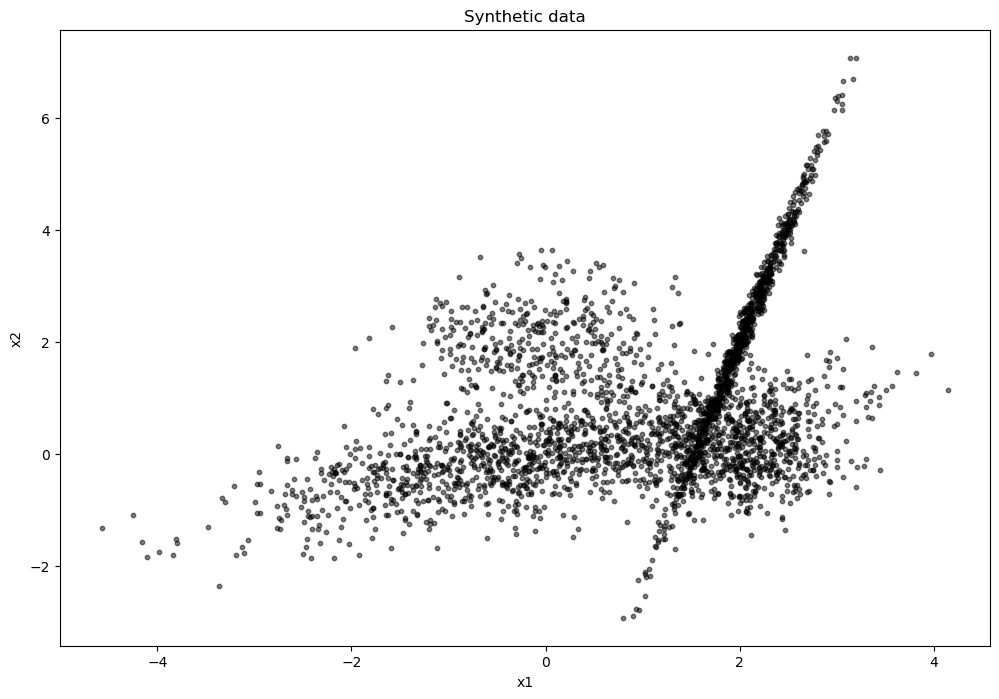

In [150]:
n_samples = [1200, 400, 600, 800]
centers = [np.array([0, 0]),
           np.array([0, 2]),
           np.array([2, 0]),
           np.array([2, 2])]
covs = [
    np.array([[0.0, -0.5], [1.5, 0.5]]),  # full covariance example
    0.7 * np.eye(2),                      # spherical-like
    0.5 * np.eye(2),                      # smaller spherical-like
    np.array([[0.0, 0.2], [0.4, 1.7]])    # full covariance example
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    # Generate multivariate normal data
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)  # shape (4000, 2)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

n_features = X.shape[1]
n_components = len(n_samples)

# Plot the synthetic data
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], s=10, color='black', alpha=0.5)
plt.title('Synthetic data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Fitting the GMM
Here, we instantiate our GaussianMixture model with the desired number of components (we set it equal to the true number for our synthetic data) and fit it to our data.
We use multiple initializations (n_init) and specify convergence tolerance and maximum iterations.

After fitting, we also print out some attributes of the fitted model (e.g. number of iterations, lower bound, convergence status).

In [157]:
# Initialize the GMM
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    tol=1e-6,
    reg_covar=1e-10,
    max_iter=1000,
    init_params='random',
    cov_init_method='eye',
    weights_init=None,
    means_init=None,
    covariances_init=None,
    n_init = 5,
    random_state=None,
    warm_start=False,
    verbose=True,
    verbose_interval=100,
    device='cpu',
)
# Fit the GMM
gmm.fit(X_tensor)

# Get predictions
y_pred = gmm.predict(X_tensor)

# Compute per-sample log-likelihoods
log_probs = gmm.score_samples(X_tensor)

# Get probabilities for each sample for each component
probs = gmm.predict_proba(X_tensor)
probs = probs.detach()

# Generate new samples
n_samples_to_generate = 4000
gmm_samples, gmm_labels = gmm.sample(n_samples_to_generate)
gmm_samples = gmm_samples.detach().cpu().numpy()
gmm_labels = gmm_labels.detach().cpu().numpy()

# Compute probabilities for each generated sample
generated_probs = gmm.predict_proba(torch.tensor(gmm_samples, dtype=torch.float32).to(device))
generated_probs = generated_probs.detach().cpu().numpy()

print('Mean per-sample log-likelihood:                        ', gmm.score(X_tensor))
print('Mean per-sample log-likelihood (torch.mean(log_probs)):', torch.mean(log_probs).item())
print('Lower bound (before last M-step):                      ', gmm.lower_bound_)
for i in range(probs.shape[0]):
    assert np.isclose(torch.sum(probs[i]).item(), 1.0), f"Probabilities for sample {i} do not sum to 1"
print('Number of iterations:                                  ', gmm.n_iter_)
print('Converged:                                             ', gmm.converged_)


[InitRun 0] Iter 0, lower bound: -3.97312
[InitRun 0] Converged at iteration 59, lower bound=-2.70336
[InitRun 1] Iter 0, lower bound: -3.69076
[InitRun 1] Iter 100, lower bound: -2.70383
[InitRun 1] Converged at iteration 117, lower bound=-2.70336
[InitRun 2] Iter 0, lower bound: -4.17624
[InitRun 2] Iter 100, lower bound: -2.79470
[InitRun 2] Converged at iteration 141, lower bound=-2.79448
[InitRun 3] Iter 0, lower bound: -3.89390
[InitRun 3] Converged at iteration 32, lower bound=-2.70336
[InitRun 4] Iter 0, lower bound: -3.86503
[InitRun 4] Converged at iteration 42, lower bound=-2.70336
Mean per-sample log-likelihood:                         -2.703359365463257
Mean per-sample log-likelihood (torch.mean(log_probs)): -2.703359365463257
Lower bound (before last M-step):                       -2.7033612728118896
Number of iterations:                                   32
Converged:                                              True


In [152]:
# weights, means, covariances of each component
for i in range(gmm.n_components):
    print(f'\nComponent {i+1}:')
    print('Weight:')
    print(gmm.weights_[i].item())
    print('Mean:')
    print(gmm.means_[i].detach().cpu().numpy())
    print('Covariance:')
    print(gmm.covariances_[i].detach().cpu().numpy())


Component 1:
Weight:
0.40691351890563965
Mean:
[-0.00260555  0.01102349]
Covariance:
[[2.0649674  0.6800351 ]
 [0.6800352  0.47188622]]

Component 2:
Weight:
0.13109558820724487
Mean:
[-0.05526054  1.9939424 ]
Covariance:
[[0.47388119 0.04737885]
 [0.04737885 0.42874056]]

Component 3:
Weight:
0.26816150546073914
Mean:
[2.0048902 2.0168593]
Covariance:
[[0.1594419  0.67552257]
 [0.6755225  2.900043  ]]

Component 4:
Weight:
0.19382932782173157
Mean:
[2.0262444  0.01810603]
Covariance:
[[0.23757133 0.01326546]
 [0.01326546 0.28340966]]


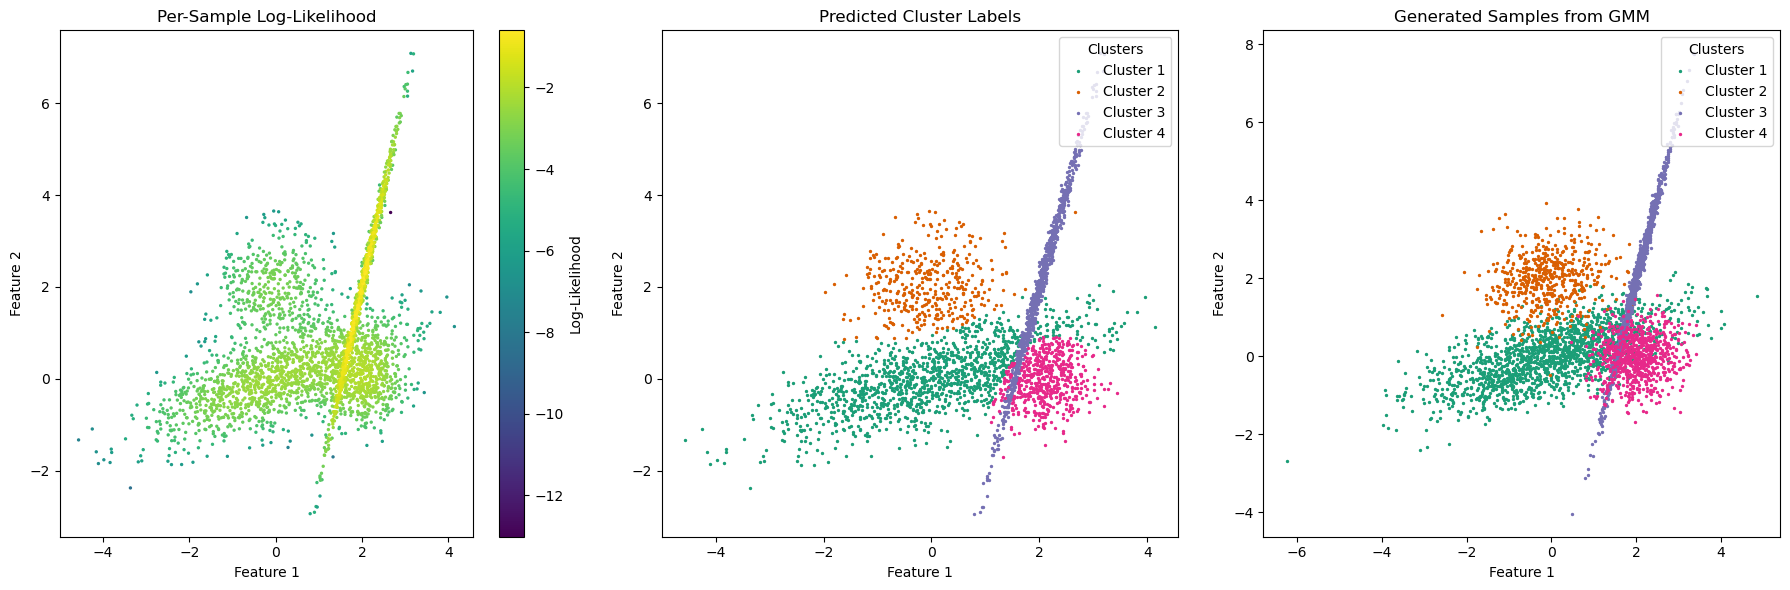

In [153]:
# Define your color map for up to 4 components (adjust if needed)
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
color_map = {label: color for label, color in enumerate(colors)}

# 1) Prepare your figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

###############################################################################
# Plot (1) - Per-Sample Log-Likelihood
###############################################################################

scatter = axs[0].scatter(
    X[:, 0], 
    X[:, 1], 
    c=log_probs, 
    cmap='viridis', 
    s=2
)
axs[0].set_title('Per-Sample Log-Likelihood')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('Log-Likelihood')

###############################################################################
# Plot (2) - Predicted Cluster Labels
###############################################################################

for cluster in range(n_components):
    cluster_points = X[y_pred == cluster]
    axs[1].scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f'Cluster {cluster + 1}',
        color=color_map[cluster],
        s=2
    )

axs[1].set_title('Predicted Cluster Labels')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')
axs[1].legend(title="Clusters", loc='upper right')

###############################################################################
# Plot (3) - Generated Samples from the GMM
###############################################################################

for cluster in range(n_components):
    cluster_samples = gmm_samples[gmm_labels == cluster]
    axs[2].scatter(
        cluster_samples[:, 0],
        cluster_samples[:, 1],
        label=f'Cluster {cluster + 1}',
        color=color_map[cluster],
        s=2
    )

axs[2].set_title('Generated Samples from GMM')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')
axs[2].legend(title="Clusters", loc='upper right')

###############################################################################
# Final Layout & Save
###############################################################################
plt.tight_layout()
plt.show()


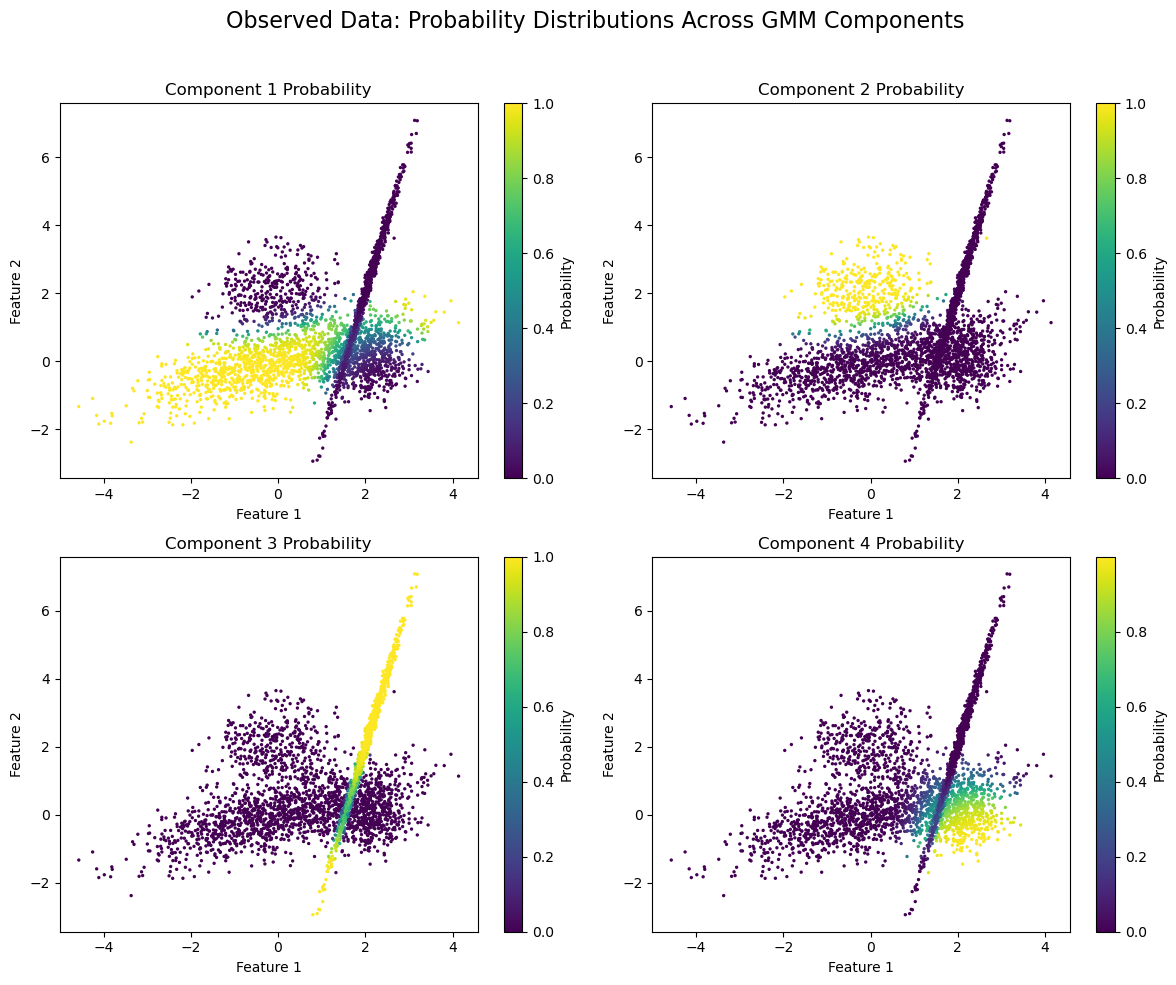

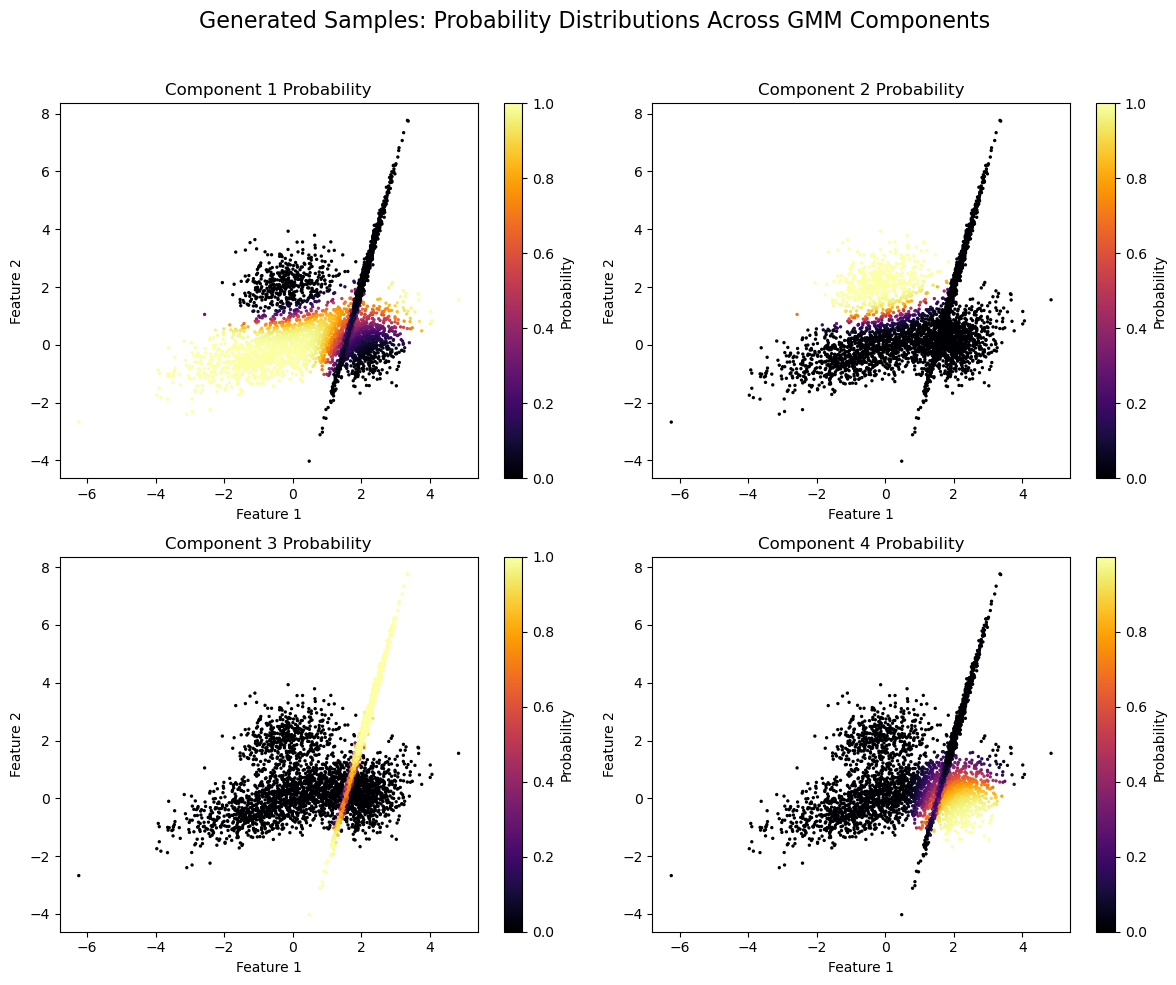

In [154]:
# Observed Data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for k, ax in enumerate(axs.ravel()):
    prob_k = probs[:, k]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=prob_k.detach().cpu().numpy(), cmap='viridis', s=2)
    ax.set_title(f'Component {k+1} Probability')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Probability')

fig.suptitle("Observed Data: Probability Distributions Across GMM Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Generated Samples
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for k, ax in enumerate(axs.ravel()):
    prob_k = generated_probs[:, k]
    scatter = ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=prob_k, cmap='inferno', s=2)
    ax.set_title(f'Component {k+1} Probability')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Probability')

fig.suptitle("Generated Samples: Probability Distributions Across GMM Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


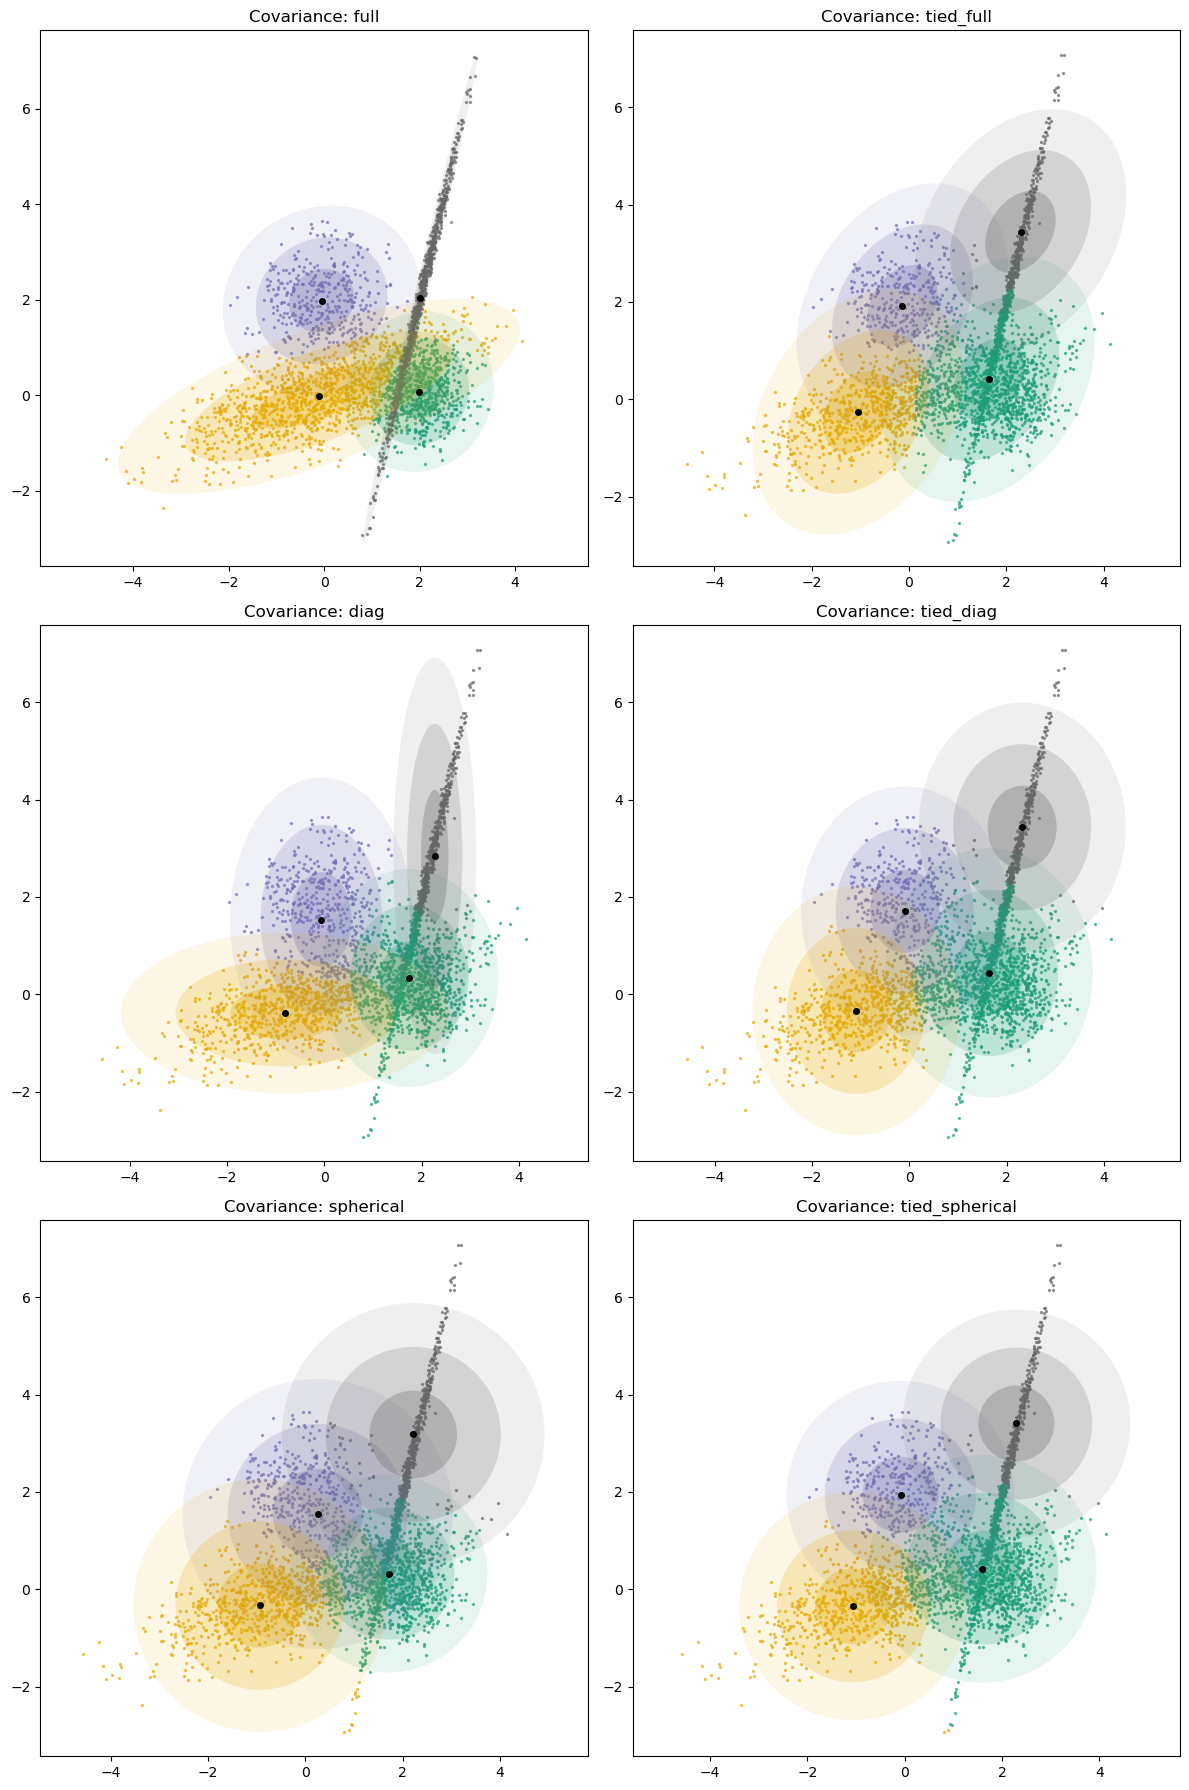

In [155]:
cov_types = ['full', 'tied_full', 'diag', 'tied_diag', 'spherical', 'tied_spherical']

torch.manual_seed(random_state)

fig, axs = plt.subplots(3, 2, figsize=(12, 18))
axs = axs.flatten()

for ax, cov_type in zip(axs, cov_types):
    gmm = GaussianMixture(
        n_features=2,
        n_components=4,
        covariance_type=cov_type,
        init_params='kmeans',
        random_state=random_state,
        device=device
    )
    gmm.fit(X_tensor)
    labels_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm_results(gmm, X, labels_pred, ax=ax, title=f'Covariance: {cov_type}')

plt.tight_layout()
plt.show()

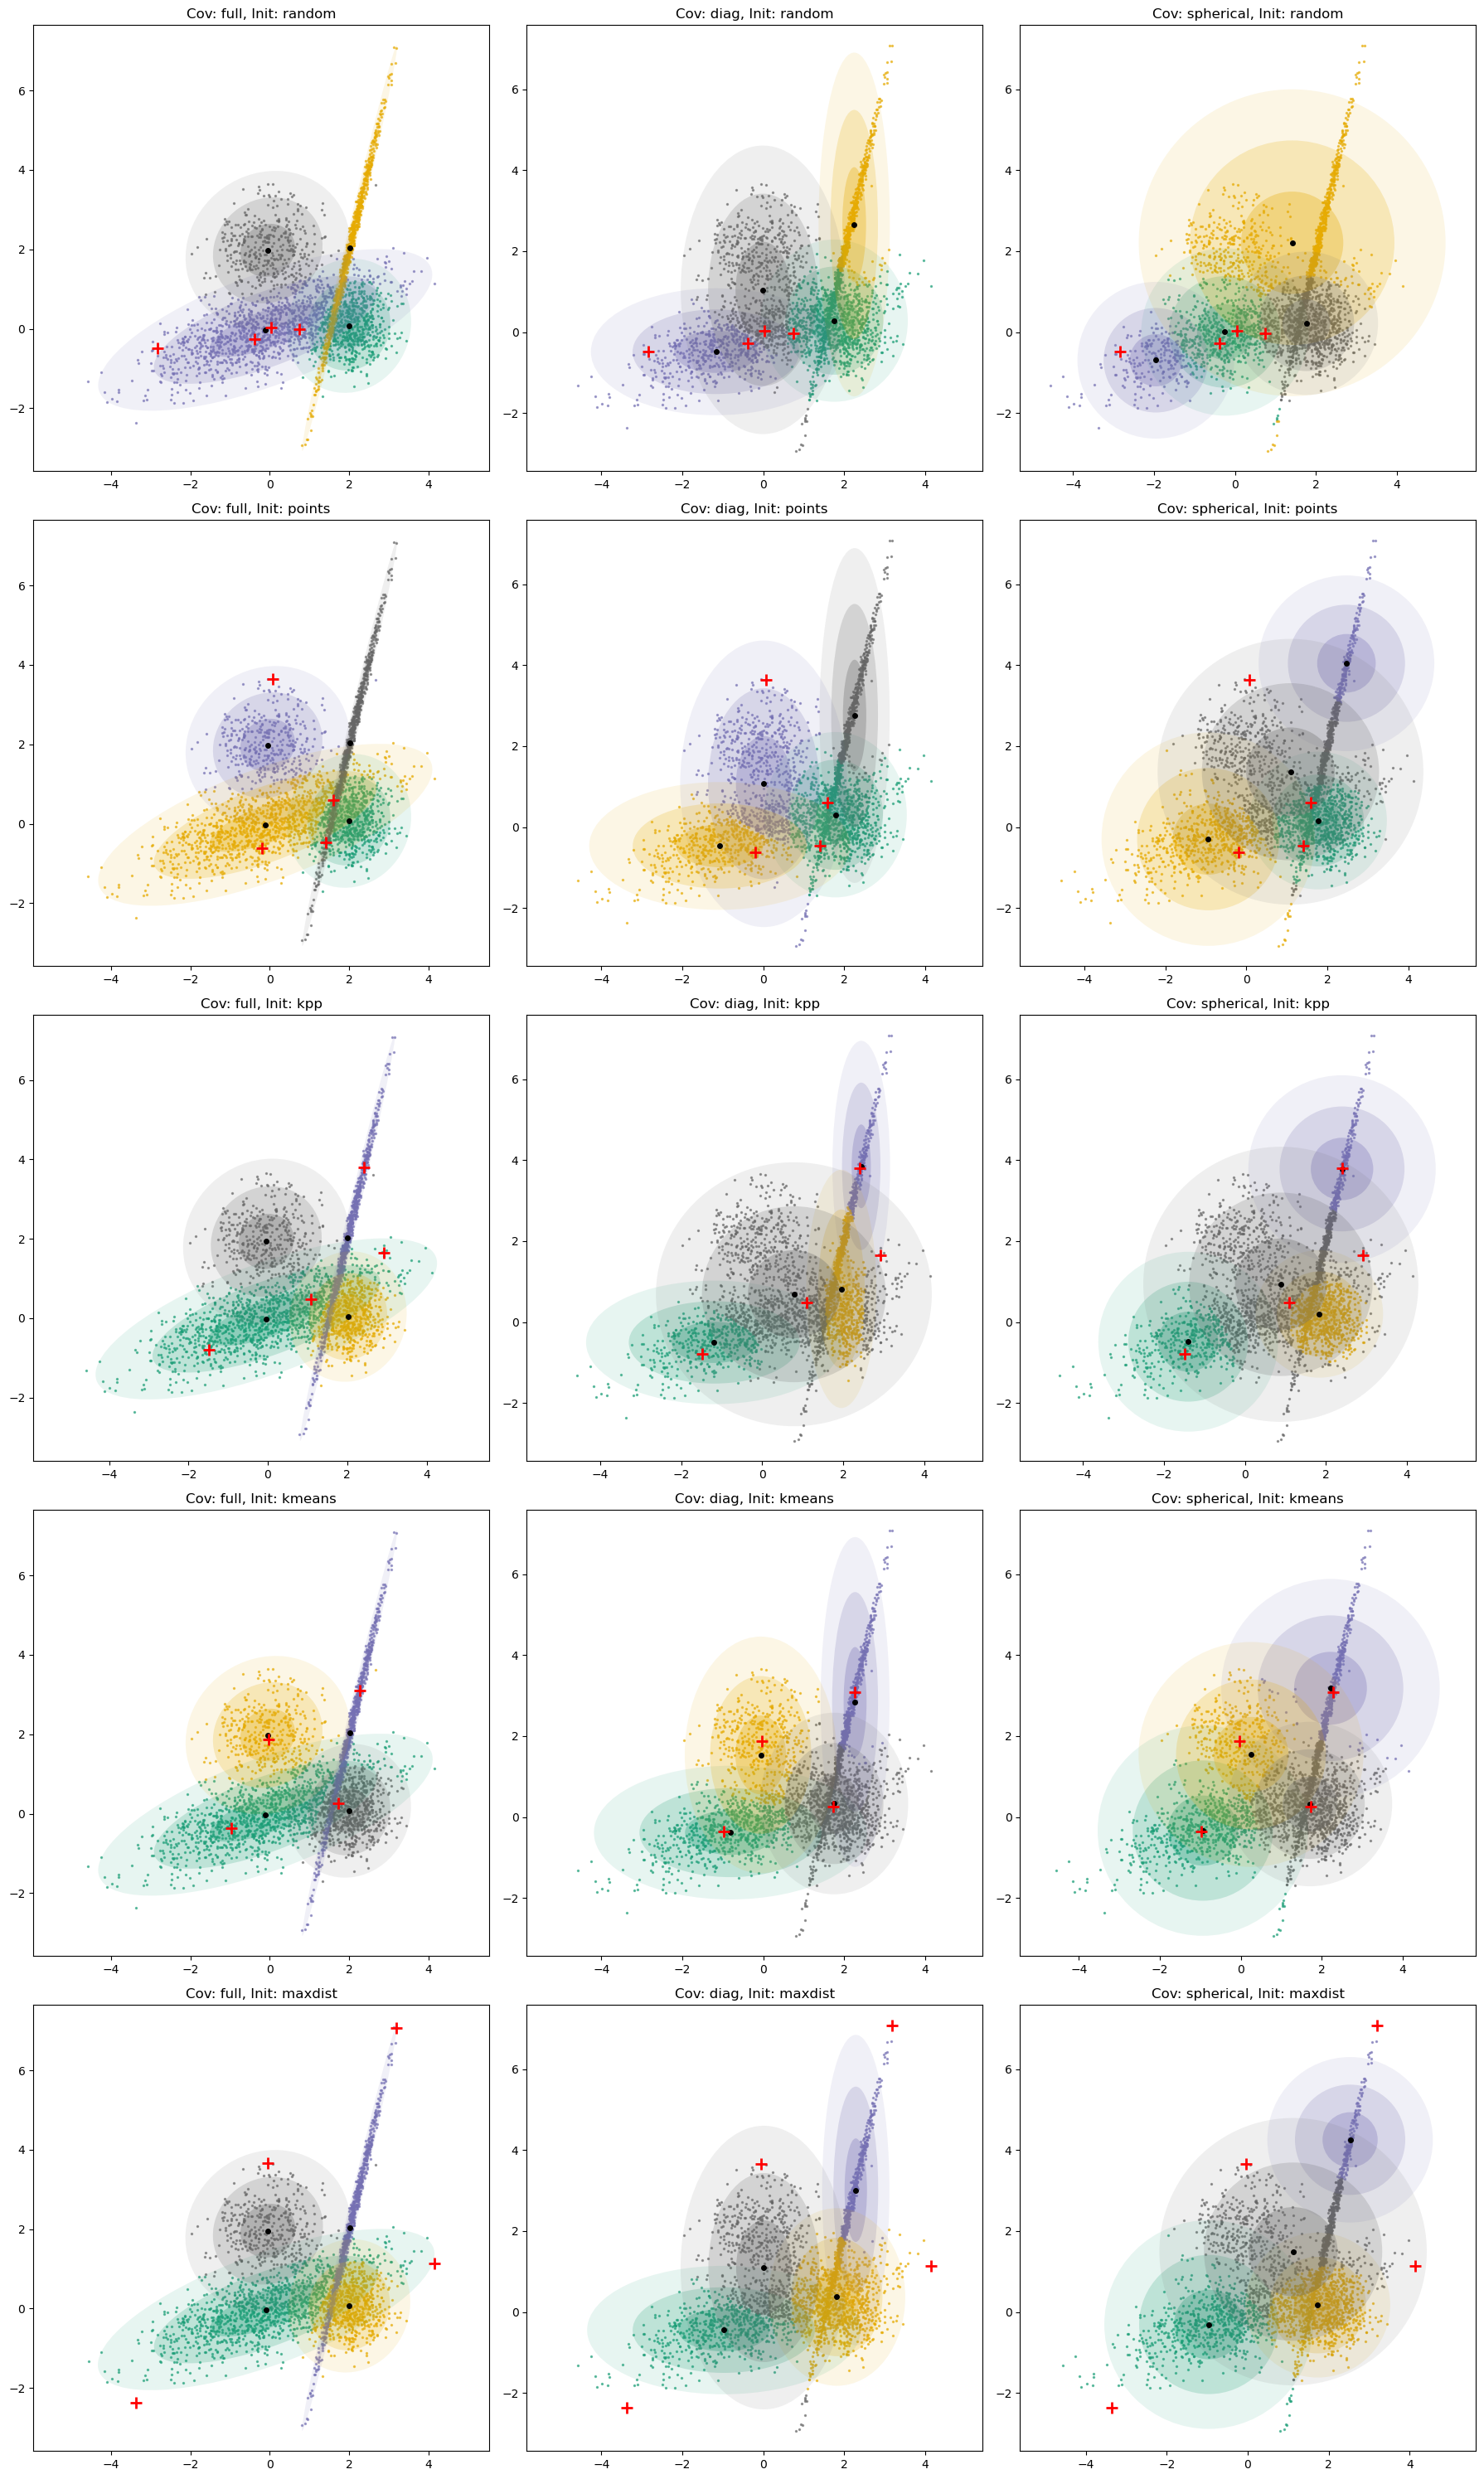

In [156]:
cov_types = ['full', 'diag', 'spherical']
init_methods = ['random', 'points', 'kpp', 'kmeans', 'maxdist']

torch.manual_seed(random_state)

from src.gmm_init import GMMInitializer

def get_init_means(method, data, k):
    """
    Returns initial means for a given method from GMMInitializer.
    """
    if method == 'random':
        return GMMInitializer.random(data, k)
    elif method == 'points':
        return GMMInitializer.points(data, k)
    elif method == 'kpp':
        return GMMInitializer.kpp(data, k)
    elif method == 'kmeans':
        return GMMInitializer.kmeans(data, k)
    elif method == 'maxdist':
        return GMMInitializer.maxdist(data, k)
    else:
        raise ValueError(f"Unknown init method: {method}")


import matplotlib.pyplot as plt

cov_types = ['full', 'diag', 'spherical']
init_methods = ['random', 'points', 'kpp', 'kmeans', 'maxdist']

fig, axs = plt.subplots(
    ncols=len(cov_types),
    nrows=len(init_methods),
    figsize=(18, 30)  # adjust as you like
)

for col_idx, method in enumerate(init_methods):
    for row_idx, cov_type in enumerate(cov_types):
        ax = axs[col_idx, row_idx]

        # 1) Get initial means from our GMMInitializer
        init_means = get_init_means(method, X_tensor, k=4)

        # 2) Create GMM with 'means_init' so it uses these means
        gmm = GaussianMixture(
            n_features=2,
            n_components=4,
            covariance_type=cov_type,
            means_init=init_means,
            init_params=None,      # or 'none' to bypass internal logic
            random_state=0,
            device=device
        )

        # 3) Fit the GMM on X_tensor
        gmm.fit(X_tensor)
        # 4) Predict cluster labels
        labels_pred = gmm.predict(X_tensor).cpu().numpy()

        # 5) Plot
        title = f'Cov: {cov_type}, Init: {method}'
        plot_gmm_results(gmm, X, labels_pred, ax=ax, title=title, init_means=init_means)

plt.tight_layout()
plt.show()
